In [1]:
# read the data in

import pandas as pd
import numpy as np
import sys

def exit_with_error(message):
    print(f"Error: {message}")
    sys.exit(1)

metadata_fname = "data\\metadata_wide.tsv"
quants_fname = "data\\proteins_wide_normalized.tsv"
targets_fname = "data\\mouse_targets_from_human_hits.txt"

metadata = pd.read_csv(metadata_fname, sep='\t', na_values=['N/A'])
data = pd.read_csv(quants_fname, sep='\t')
data = data.fillna(0)
targets = pd.read_csv(targets_fname, sep='\t')
protein_names = data['protein'].values

print("Metadata shape:", metadata.shape)
print("Data shape:", data.shape)

Metadata shape: (120, 18)
Data shape: (5360, 121)


Data shape: (100, 5360)
Doses: [75.   0.  75.  10.  32.5 75.  75.  32.5 10.   0.  75.  10.  32.5 32.5
 75.   0.  75.  10.  10.  32.5 10.  32.5 75.  10.  32.5 32.5  0.  75.
 75.  10.   0.  10.   0.  32.5 75.  32.5 32.5 10.  75.  75.  32.5 75.
 75.  10.  10.  75.   0.  32.5 32.5  0.  10.  10.  75.  75.   0.  32.5
 75.  10.  10.  32.5 32.5 75.  10.   0.  75.  10.  10.  32.5  0.  32.5
 75.  10.  32.5 75.  32.5 75.  10.  32.5  0.  10.  75.  75.  10.  32.5
 32.5  0.  32.5 32.5 10.  75.  10.  75.  75.  10.  32.5  0.  75.  10.
  0.  32.5]


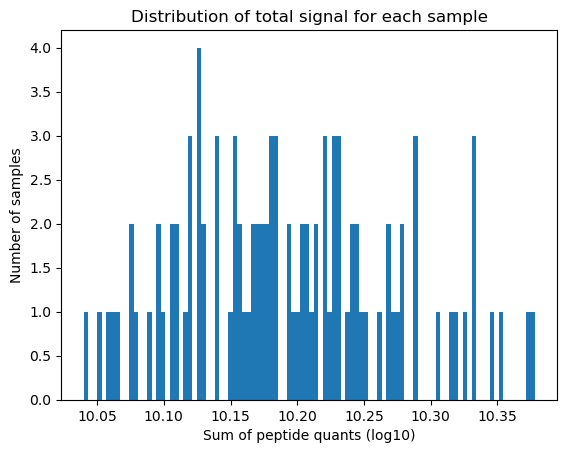

In [2]:
# transform data into what Justin's code is expecting

import matplotlib.pyplot as plt

valid_replicates = metadata[
    (metadata['TargetDose_cGy'].notna()) & 
    (metadata['TargetDose_cGy'] != 'na')
]['replicate'].tolist()

X = []
rad = []
rates = []
ir_type = []

for idx in valid_replicates:
  for sample in data.columns[:]:
    if idx in sample:
      s_rad = metadata[metadata['replicate'] == idx]['TargetDose_cGy'].values[0]
      s_ir_type = metadata[metadata['replicate'] == idx]['IR_Type'].values[0]

      rad.append(s_rad)
      ir_type.append(s_ir_type)
      X.append(data[sample].values)

X = np.array(X)
rad = np.array(rad).astype(float)
ir_type = np.array(ir_type)

print("Data shape:", X.shape)
print("Doses:", rad)

total_signal = np.sum(X, axis=1)
plt.hist(np.log10(total_signal), bins = 100)
plt.title('Distribution of total signal for each sample')
plt.ylabel('Number of samples')
plt.xlabel('Sum of peptide quants (log10)')
plt.show()

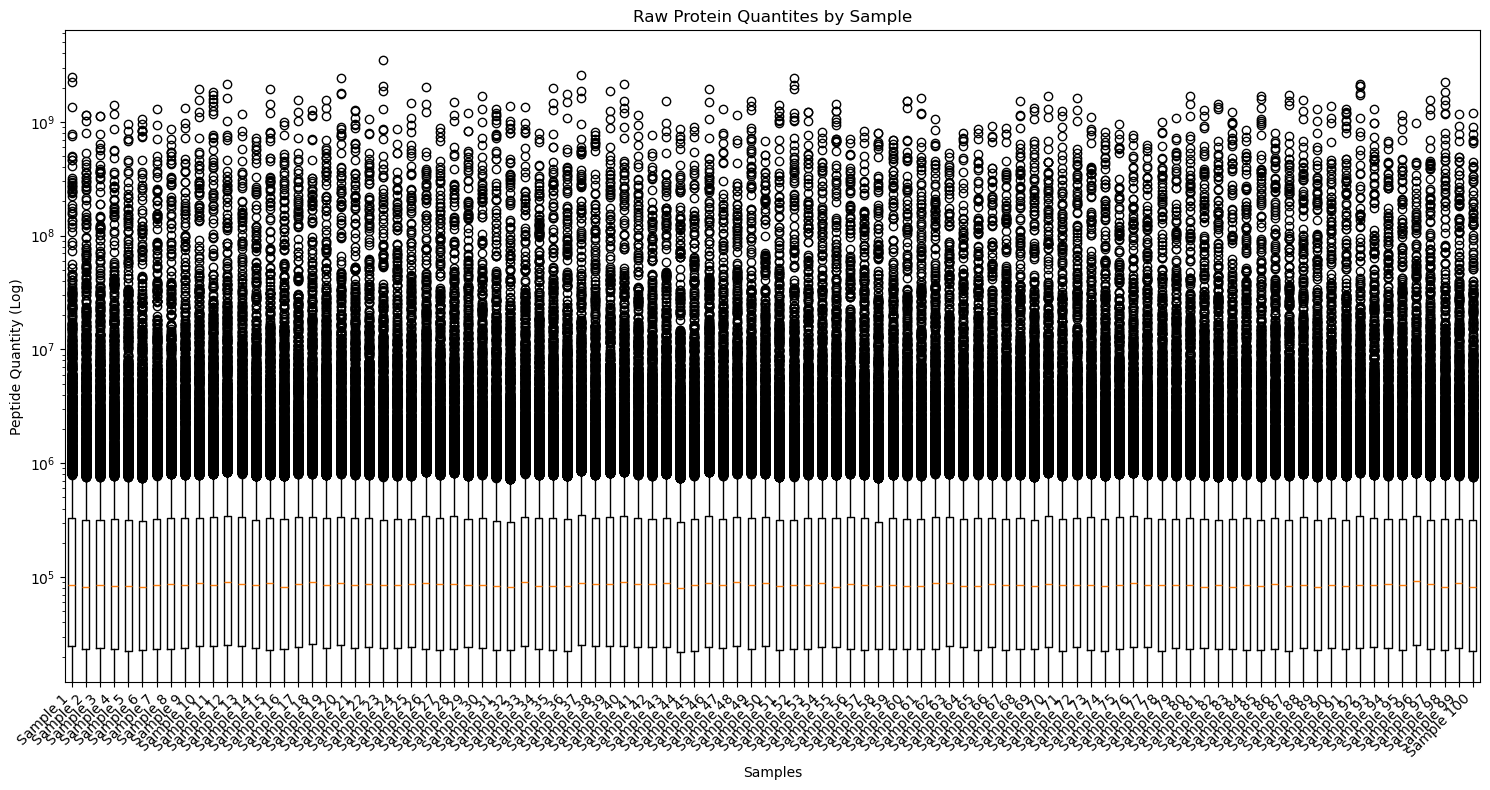

In [3]:
# Create the box plot
plt.figure(figsize=(15, 8))
plt.boxplot(X.T)  # Transpose the data

plt.title('Raw Protein Quantites by Sample')
plt.xlabel('Samples')
plt.ylabel('Peptide Quantity (Log)')
plt.xticks(range(1, X.shape[0] + 1), [f'Sample {i+1}' for i in range(X.shape[0])], rotation=45, ha='right')

# Use log scale for y-axis as peptide quantities often span several orders of magnitude
plt.yscale('log')

plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

In [4]:
# def mad_row_normalize(df):

#     row_medians = df.median(axis=1) # medians for each row

#     # Calculate the MAD for each row
#     def mad(row):
#         median = np.median(row)
#         return np.median(np.abs(row - median))

#     row_mads = df.apply(mad, axis=1)

#     # Normalize each row by subtracting the median and dividing by the MAD
#     df_normalized = df.sub(row_medians, axis=0).div(row_mads, axis=0)

#     return df_normalized

# labeled_X_log = np.log1p(X)
# labeled_X_median_normalized = mad_row_normalize(pd.DataFrame(labeled_X_log))
# print(labeled_X_median_normalized.shape)  # Should still be (N, M)

# labeled_X_scaled = labeled_X_median_normalized
# labeled_X_scaled = labeled_X_scaled.to_numpy()

# X = labeled_X_scaled



In [5]:
import numpy as np

def median_normalize(data):
    """
    Median normalize a 2D numpy array with samples as rows and features as columns.
    
    The function performs two steps:
    1. For each sample (row), divide all values by the median of that sample
    2. Multiply all values by the global median of the original data
    
    Parameters:
    -----------
    data : numpy.ndarray
        2D array with samples as rows and features as columns
    
    Returns:
    --------
    numpy.ndarray
        Median normalized array
    """
    # Calculate the global median of all data (excluding NaN values)
    global_median = np.nanmedian(data)
    
    # Calculate median for each sample (row)
    sample_medians = np.nanmedian(data, axis=1)
    
    # Avoid division by zero or very small values
    epsilon = np.finfo(float).eps
    sample_medians = np.where(sample_medians < epsilon, epsilon, sample_medians)
    
    # Divide each sample by its median and then multiply by the global median
    # Using broadcasting to divide each row by its corresponding median
    normalized_data = data / sample_medians[:, np.newaxis] * global_median
    
    return normalized_data

# Apply median normalization
normalized_data_df = median_normalize(X)
X = normalized_data_df

In [6]:
X = np.log1p(X)

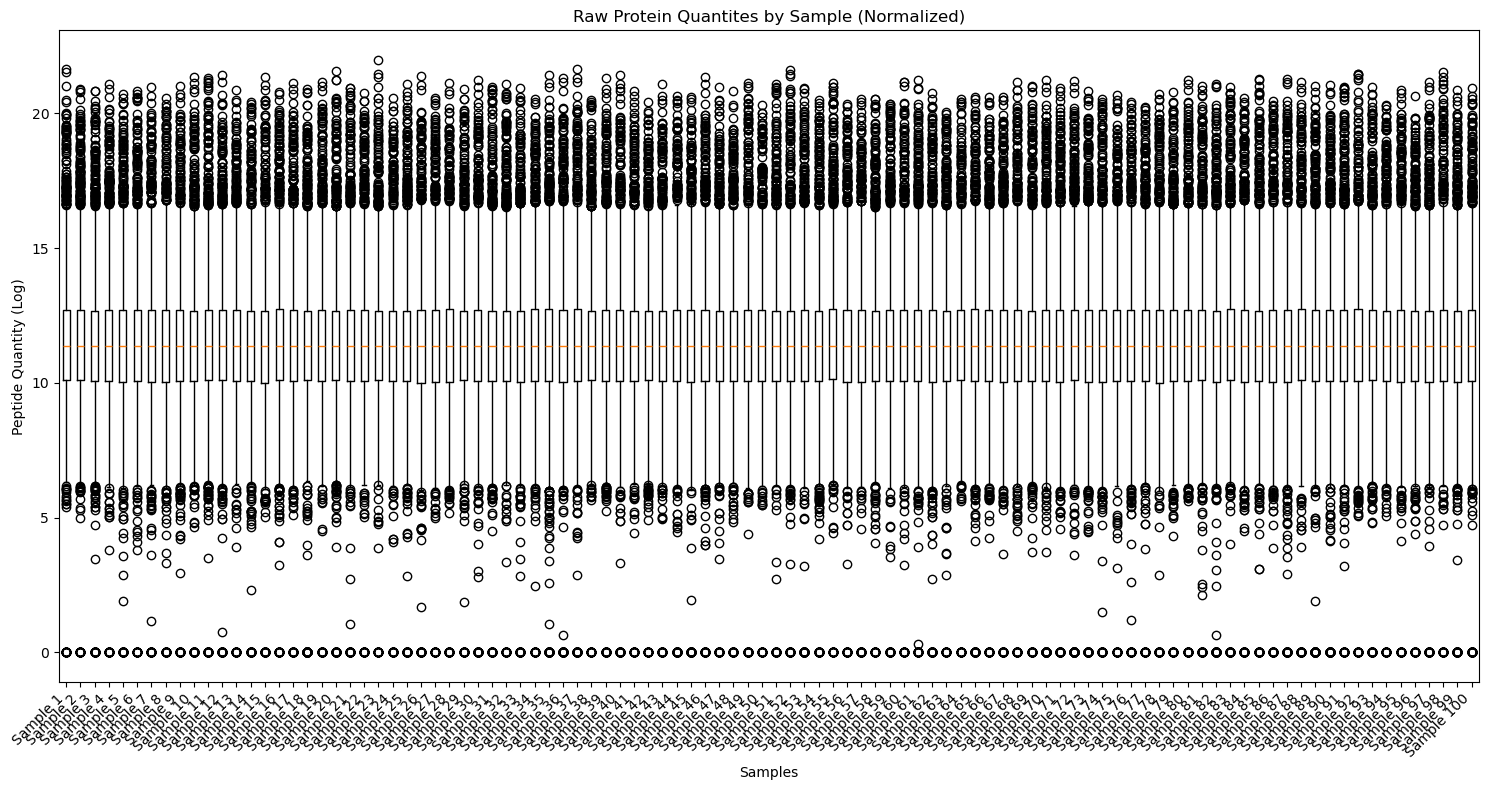

In [7]:
# Create the box plot
plt.figure(figsize=(15, 8))
plt.boxplot(X.T)  # Transpose the data

plt.title('Raw Protein Quantites by Sample (Normalized)')
plt.xlabel('Samples')
plt.ylabel('Peptide Quantity (Log)')
plt.xticks(range(1, X.shape[0] + 1), [f'Sample {i+1}' for i in range(X.shape[0])], rotation=45, ha='right')

plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

C:\Users\msft\AppData\Local\Temp\ipykernel_52580\3615899121.py:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=mad_series, shade=True)


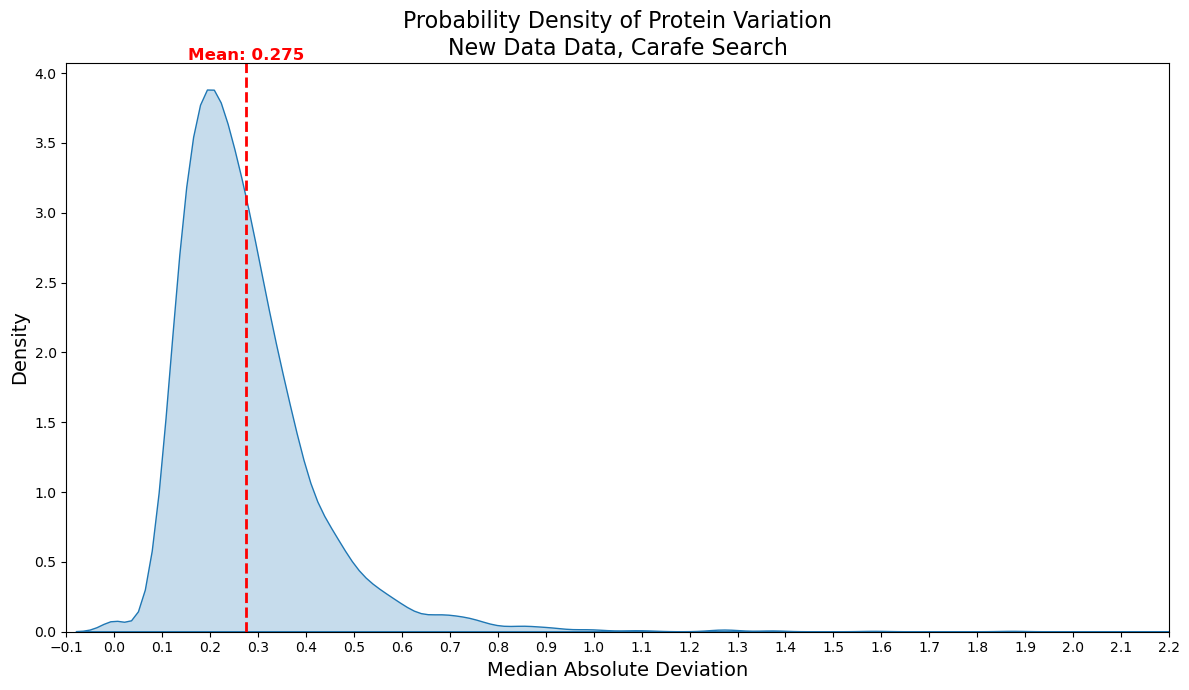

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import median_abs_deviation

mad = median_abs_deviation(X, axis=0)
mad_series = pd.Series(mad, name='Median Absolute Deviation')
mean_mad = np.mean(mad)

# Plot the probability density
plt.figure(figsize=(12, 7))
sns.kdeplot(data=mad_series, shade=True)

plt.title('Probability Density of Protein Variation\nNew Data Data, Carafe Search', fontsize=16)
plt.xlabel('Median Absolute Deviation', fontsize=14)
plt.ylabel('Density', fontsize=14)

plt.xlim(-0.1, 2.2)
plt.xticks(np.arange(-0.1, 2.3, 0.1))

plt.axvline(mean_mad, color='red', linestyle='--', linewidth=2)

plt.text(mean_mad, plt.ylim()[1], f'Mean: {mean_mad:.3f}', 
         horizontalalignment='center', verticalalignment='bottom',
         color='red', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.show()

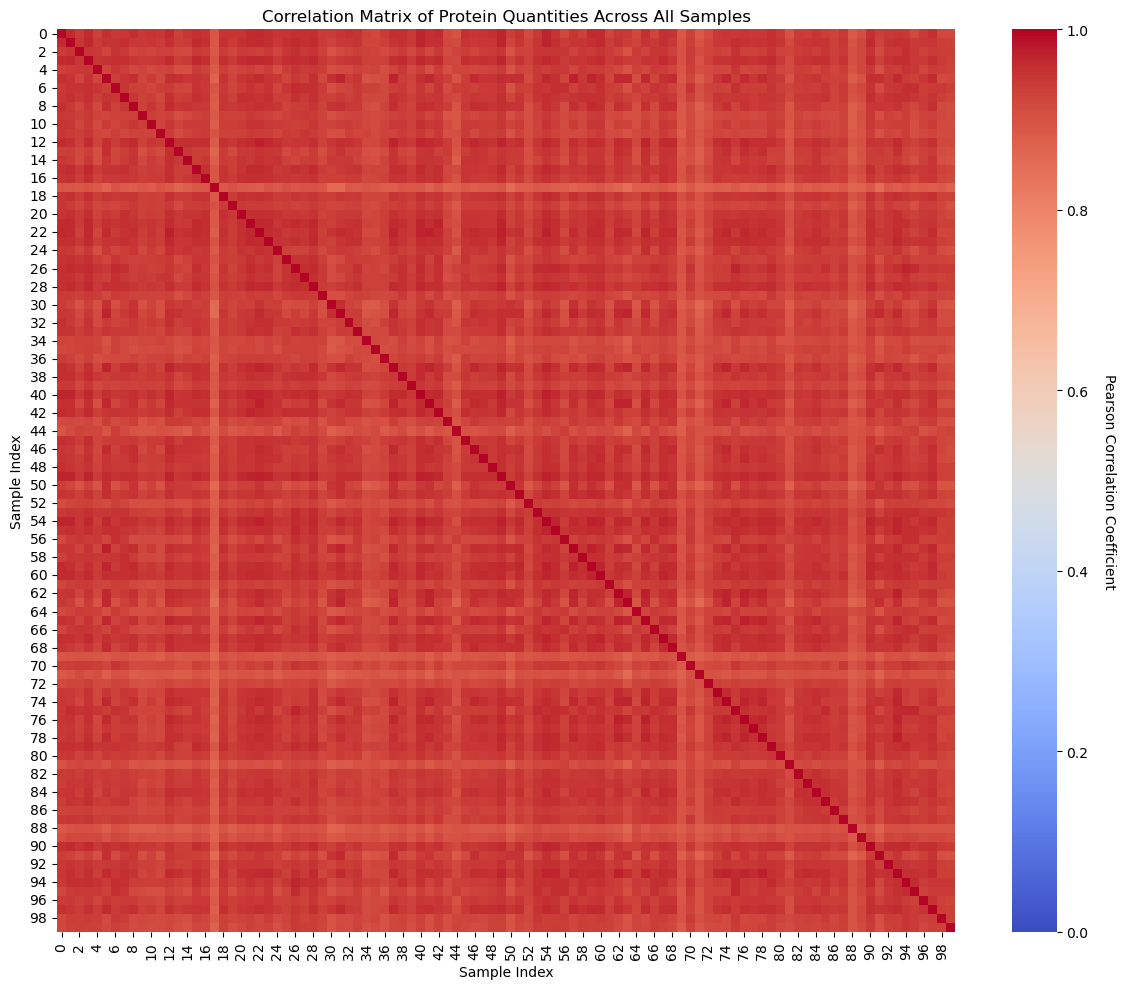

Number of samples: 100
Number of proteins: 5360
Using unlogged values
Average correlation (excluding self-correlations): 0.9338


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

def plot_protein_correlation_matrix(unlogged_X, use_log=True, save_path=None):
    """
    Create a correlation matrix heatmap comparing protein quantities across all samples.
    
    Parameters:
    unlogged_X (np.array): 2D array with samples as rows, proteins as columns, and quantities as values
    use_log (bool, optional): Whether to use log-transformed values for protein quantities. Defaults to True.
    save_path (str, optional): Path to save the plot. If None, the plot will be displayed instead.
    
    Returns:
    np.array: The correlation matrix
    """
    
    # Apply log transformation if use_log is True
    tmpX = np.log2(unlogged_X) if use_log else unlogged_X
    
    # Compute the correlation matrix
    corr_matrix = np.corrcoef(tmpX)
    
    # Create the heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, cmap='coolwarm', center=0.5, vmin=0, vmax=1)
    
    plt.title('Correlation Matrix of Protein Quantities Across All Samples')
    plt.xlabel('Sample Index')
    plt.ylabel('Sample Index')
    
    # Add colorbar label
    cbar = plt.gcf().axes[-1]
    cbar.set_ylabel('Pearson Correlation Coefficient', rotation=270, labelpad=20)
    
    plt.tight_layout()
    
    # Save or display the plot
    if save_path:
        plt.savefig(save_path)
        plt.close()
    else:
        plt.show()
    
    # Print summary statistics
    print(f"Number of samples: {tmpX.shape[0]}")
    print(f"Number of proteins: {tmpX.shape[1]}")
    print(f"Using {'log-transformed' if use_log else 'unlogged'} values")
    
    # Calculate and print the average correlation, excluding self-correlations
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
    upper_triangle = corr_matrix[mask]
    average_correlation = np.mean(upper_triangle)
    print(f"Average correlation (excluding self-correlations): {average_correlation:.4f}")
    
    return corr_matrix

corr_matrix = plot_protein_correlation_matrix(X, use_log=False)

In [10]:
# features = pd.read_csv(targets_fname, sep='\t')
# idxs = []
# for idx,protein in enumerate(protein_names):
#   f = features[features['Protein'] == protein]
#   if len(f) > 0:
#     idxs.append(idx)
# print(len(idxs))
# top_protein_names = protein_names[idxs]
# s_idxs = np.argsort(top_protein_names)
# sorted_names = top_protein_names[s_idxs]
# idxs = np.array(idxs)[s_idxs]

In [11]:
# # Create the box plot
# plt.figure(figsize=(15, 8))
# plt.boxplot(X[:,idxs].T)  # Transpose the data

# plt.title('Raw Protein Quantites by Sample (Targets)')
# plt.xlabel('Samples')
# plt.ylabel('Peptide Quantity (Log)')
# plt.xticks(range(1, X.shape[0] + 1), [f'Sample {i+1}' for i in range(X.shape[0])], rotation=45, ha='right')

# plt.tight_layout()  # Adjust layout to prevent clipping of labels
# plt.show()

In [12]:
# # functions for ElasticNet hyperparameter optimization and visualization

# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.model_selection import RepeatedKFold
# from sklearn.linear_model import ElasticNet
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import mean_squared_error, mean_absolute_error

# def optimize_elasticnet_hyperparameters(X, y, alphas=None, l1_ratios=None, n_splits=10, n_repeats=5, random_state=1966, scoring='neg_mean_squared_error'):
#     if alphas is None:
#         alphas = np.logspace(-6, 6, 20)
#     if l1_ratios is None:
#         l1_ratios = np.linspace(0.1, 1.0, 10)
    
#     print(f"Using scoring: {scoring}")
    
#     rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)
    
#     scores = np.zeros((len(l1_ratios), len(alphas), n_splits * n_repeats))
    
#     for i, l1_ratio in enumerate(l1_ratios):
#         for j, alpha in enumerate(alphas):
#             for k, (train, test) in enumerate(rkf.split(X)):

#                 X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]

#                 ss = StandardScaler()
#                 ss.fit(X_train)

#                 model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=random_state, max_iter=500000, selection='cyclic')
#                 model.fit(ss.transform(X_train), y_train)
#                 y_pred = model.predict(ss.transform(X_test))
#                 if scoring == 'neg_mean_squared_error':
#                     scores[i, j, k] = -mean_squared_error(y_test, y_pred)
#                 elif scoring == 'neg_mean_absolute_error':
#                     scores[i, j, k] = -mean_absolute_error(y_test, y_pred)

#                 # print(l1_ratio, alpha, k, scores[i, j, k])
    
#     mean_scores = np.mean(scores, axis=2)
#     best_idx = np.unravel_index(np.argmax(mean_scores), mean_scores.shape)
#     best_l1_ratio = l1_ratios[best_idx[0]]
#     best_alpha = alphas[best_idx[1]]
    
#     return best_alpha, best_l1_ratio, scoring, scores, alphas, l1_ratios

# def plot_elasticnet_heatmap(scores, alphas, l1_ratios, scoring):
#     mean_scores = np.mean(scores, axis=2)
    
#     # Ensure alphas and l1_ratios are numpy arrays
#     alphas = np.asarray(alphas)
#     l1_ratios = np.asarray(l1_ratios)
    
#     # Sort alphas and l1_ratios
#     sorted_alpha_indices = np.argsort(alphas)
#     sorted_l1_ratio_indices = np.argsort(l1_ratios)
    
#     alphas_sorted = alphas[sorted_alpha_indices]
#     l1_ratios_sorted = l1_ratios[sorted_l1_ratio_indices]
#     mean_scores_sorted = mean_scores[sorted_l1_ratio_indices][:, sorted_alpha_indices]
    
#     plt.figure(figsize=(15, 10))
#     ax = sns.heatmap(mean_scores_sorted, cmap='viridis', annot=False)
    
#     # Set x-axis ticks and labels
#     ax.set_xticks(np.arange(len(alphas_sorted)) + 0.5)
#     ax.set_xticklabels([f'{alpha:.2e}' for alpha in alphas_sorted], rotation=45, ha='right')
    
#     # Set y-axis ticks and labels
#     ax.set_yticks(np.arange(len(l1_ratios_sorted)) + 0.5)
#     ax.set_yticklabels([f'{l1_ratio:.3f}' for l1_ratio in l1_ratios_sorted], rotation=0)
    
#     plt.title(f'ElasticNet Hyperparameter Heatmap\nScoring: {scoring}')
#     plt.xlabel('Alpha')
#     plt.ylabel('L1 Ratio')
#     plt.tight_layout()
#     plt.show()

In [13]:
# # ElasticNet hyperparameter optimization (and visualization)

# labeled_X = X[[r >= 0 for r in rad]][:,idxs]
# y = rad[[r >= 0 for r in rad]]

# l1_ratios = [.5, .75, .9, .99, .999, 1]
# alphas = [1E-4, 1E-3, 1E-2, 1E-1, 1, 10]

# best_alpha, best_l1_ratio, used_scoring, scores, alphas, l1_ratios = optimize_elasticnet_hyperparameters(
#     labeled_X, y, l1_ratios=l1_ratios, alphas=alphas, n_splits=10, n_repeats=5, scoring='neg_mean_absolute_error'
# )

# print(f"Best alpha: {best_alpha}")
# print(f"Best l1_ratio: {best_l1_ratio}")
# print(f"Scoring metric used: {used_scoring}")

# # Plot the heatmap
# plot_elasticnet_heatmap(scores, alphas, l1_ratios, used_scoring)

In [14]:
# # ElasticNet hyperparameter optimization (and visualization)
# # more fine tuning

# labeled_X = X[[r >= 0 for r in rad]][:,idxs]
# y = rad[[r >= 0 for r in rad]]

# l1_ratios = [0.01, .025, .05, .075, .1]
# alphas = [ .01, .025, .05,]

# best_alpha, best_l1_ratio, used_scoring, scores, alphas, l1_ratios = optimize_elasticnet_hyperparameters(
#     labeled_X, y, l1_ratios=l1_ratios, alphas=alphas, n_splits=19, n_repeats=5, scoring='neg_mean_absolute_error'
# )

# print(f"Best alpha: {best_alpha}")
# print(f"Best l1_ratio: {best_l1_ratio}")
# print(f"Scoring metric used: {used_scoring}")

# # Plot the heatmap
# plot_elasticnet_heatmap(scores, alphas, l1_ratios, used_scoring)

In [15]:
# # figure in slack used 19 fold CV, alpha 0.3, l1 1

# import scipy
# import xgboost as xgb
# from sklearn.metrics import ConfusionMatrixDisplay
# from sklearn.model_selection import RepeatedStratifiedKFold, RepeatedKFold
# from sklearn.linear_model import ElasticNet, ElasticNetCV
# from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer

# labeled_X = X[[r >= 0 for r in rad]][:,idxs]
# y = rad[[r >= 0 for r in rad]]

# print(y)

# m = sum(y)/len(y)
# print("Nieve MAE:", sum([np.abs(x-m) for x in y])/len(y))

# pred_i = []
# true_i = []
# all_coeffs = []
# all_coeffs_nonzero = []

# splits = 10
# repeats = 5
# skf = RepeatedKFold(n_splits=splits, n_repeats = repeats, random_state=1966)
# for train, test in skf.split(labeled_X, y):
#   X_train, X_test, y_train, y_test = labeled_X[train], labeled_X[test], y[train], y[test]

#   ss = StandardScaler()
#   ss.fit(X_train)

#   #reg = ElasticNetCV(random_state=1966, max_iter = 500000, selection = 'cyclic')
#   #reg = ElasticNet(random_state=1966, max_iter = 500000, selection = 'cyclic', alpha = .4, l1_ratio = .999)

#   # used in slack message with targets.tsv
#   reg = ElasticNet(random_state=1966, max_iter = 500000, selection = 'cyclic', alpha = .5, l1_ratio = 0.9)

#   # best for boruta features
#   #reg = ElasticNet(random_state=1966, max_iter = 500000, selection = 'cyclic', alpha = 1, l1_ratio = 1)

#   reg.fit(ss.transform(X_train), y_train)

#   #print(reg.alpha_, reg.l1_ratio_)

#   if len(all_coeffs) == 0:
#     all_coeffs = reg.coef_
#     all_coeffs_nonzero = (reg.coef_ != 0).astype(int)
#   else:
#     all_coeffs += reg.coef_
#     all_coeffs_nonzero += (reg.coef_ != 0).astype(int)


#   pred_i += [x for x in reg.predict(ss.transform(X_test))]
#   true_i += [x for x in y_test]

# pred_i = [min(75, max(x,0)) for x in pred_i]

# # write the predictions out
# np.savetxt('regression_cv_fold_test_predictions.txt', np.column_stack((pred_i, true_i)), delimiter='\t', header='Predicted\tTrue', comments='')

# plt.scatter(true_i, pred_i, c='r', s=52, alpha=0.1)
# b, a, r_value, p_value, std_err = scipy.stats.linregress(true_i, pred_i)
# xseq = np.linspace(min(true_i), max(true_i), num=2)
# plt.plot(xseq, a + b * xseq, c = 'r', label = f'Best fit line \n (r^2={round(r_value,2)}, mae={round(np.mean([np.abs(x - y) for x,y in zip(pred_i, true_i)]),2)})')
# plt.legend()
# plt.xlabel('True Dose')
# plt.ylabel('Predicted Dose')
# plt.title('Comparison of predicted to true dose\nMouse skin disc regression, Elastic Net, Pelt Features')
# plt.show()

# means = []
# true = []
# errors = []
# for d in set(true_i):
#   p = np.array(pred_i)[true_i == d]
#   means.append(np.mean(p))
#   errors.append(np.std(p))
#   true.append(d)

# plt.errorbar(true, means, errors, linestyle='None', fmt='o', capsize = 5, ecolor='black', color='red', label = "Mean predicted dose (1 std. dev.)")

# b, a, r_value, p_value, std_err = scipy.stats.linregress(true_i, pred_i)
# xseq = np.linspace(min(true_i), max(true_i), num=2)
# plt.plot(xseq, a + b * xseq, c = 'r', label = f'Best fit line \n (r^2={round(r_value,2)}, mae={round(np.mean([np.abs(x - y) for x,y in zip(pred_i, true_i)]),2)})')
# plt.legend()
# plt.xlabel('True Dose')
# plt.ylabel('Average Predicted Dose')
# plt.title('Comparison of predicted to true dose\n\nMouse skin disc regression, Elastic Net, Pelt Feature2')
# plt.show()

# y_preds = []
# y_true_binned = []  # Create a new list for binned true values

# for x, t in zip(pred_i, true_i):
#     # Bin the predicted values
#     if x < 0.5:
#         y_preds.append(0)
#     else:
#         y_preds.append(int((2.5+x)/5)*5)
    
#     # Bin the true values using the same logic
#     if t < 0.5:
#         y_true_binned.append(0)
#     else:
#         y_true_binned.append(int((2.5+t)/5)*5)

# fig, ax = plt.subplots(figsize=(6, 6))
# # Use the binned true values instead of the original continuous values
# ConfusionMatrixDisplay.from_predictions(y_true_binned, y_preds, ax=ax, colorbar=False)
# ax.tick_params(axis='both', which='major', labelsize=12)
# ax.set_xlabel("Predicted Dose")
# ax.set_ylabel("True Dose")
# ax.set_title('Cross validated confusion matrix\n\nMouse skin disc regression, Elastic Net, Pelt Features')
# plt.show()

# print("Number of proteins with all-zero coeffs:", sum(all_coeffs < 1E-12))
# print("Highest weighted protein:", sorted_names[np.argmax(all_coeffs)])
# print()
# print("Proteins with non-zero coefficients:")
# for p in sorted_names[all_coeffs > 1E-12]:
#   print(p)

In [16]:
# # ElasticNet hyperparameter optimization (and visualization)

# labeled_X = X[[r >= 0 for r in rad]]
# y = rad[[r >= 0 for r in rad]]

# l1_ratios = [.5, .75, .9, .99, .999, 1]
# alphas = [1E-4, 1E-3, 1E-2, 1E-1, 1, 10]

# best_alpha, best_l1_ratio, used_scoring, scores, alphas, l1_ratios = optimize_elasticnet_hyperparameters(
#     labeled_X, y, l1_ratios=l1_ratios, alphas=alphas, n_splits=10, n_repeats=5, scoring='neg_mean_absolute_error'
# )

# print(f"Best alpha: {best_alpha}")
# print(f"Best l1_ratio: {best_l1_ratio}")
# print(f"Scoring metric used: {used_scoring}")

# # Plot the heatmap
# plot_elasticnet_heatmap(scores, alphas, l1_ratios, used_scoring)

[75.   0.  75.  10.  32.5 75.  75.  32.5 10.   0.  75.  10.  32.5 32.5
 75.   0.  75.  10.  10.  32.5 10.  32.5 75.  10.  32.5 32.5  0.  75.
 75.  10.   0.  10.   0.  32.5 75.  32.5 32.5 10.  75.  75.  32.5 75.
 75.  10.  10.  75.   0.  32.5 32.5  0.  10.  10.  75.  75.   0.  32.5
 75.  10.  10.  32.5 32.5 75.  10.   0.  75.  10.  10.  32.5  0.  32.5
 75.  10.  32.5 75.  32.5 75.  10.  32.5  0.  10.  75.  75.  10.  32.5
 32.5  0.  32.5 32.5 10.  75.  10.  75.  75.  10.  32.5  0.  75.  10.
  0.  32.5]
Nieve MAE: 24.420000000000005


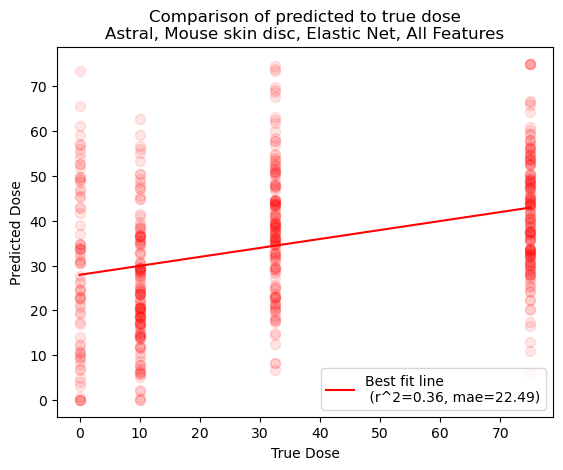

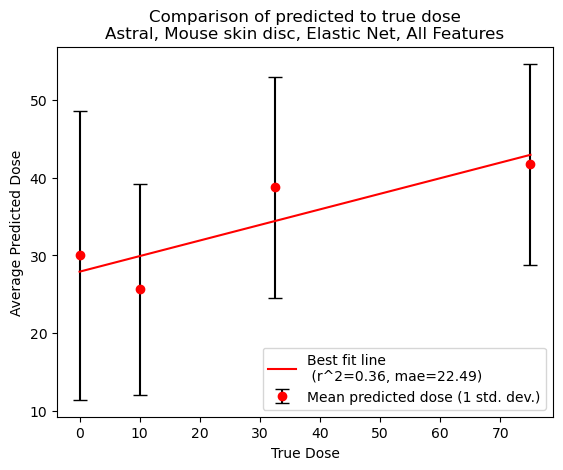

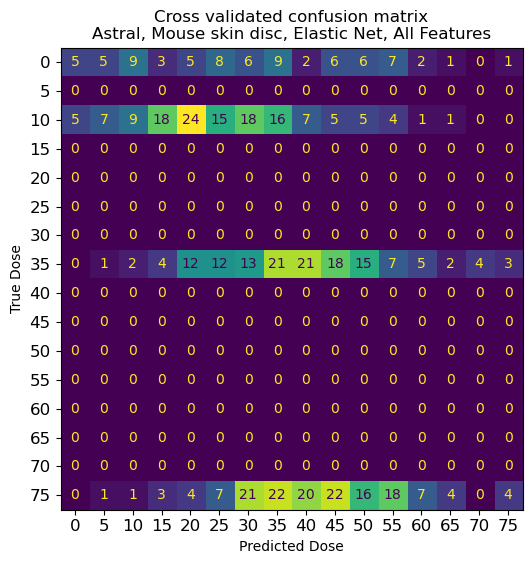

Number of proteins with all-zero coeffs: 5135
Highest weighted protein: sp|P50396|GDIA_MOUSE

Proteins with non-zero coefficients:
sp|A1IGU4|ARH37_MOUSE
sp|A2AT37|RENT2_MOUSE
sp|B2RY56|RBM25_MOUSE
sp|D3Z4S3|PTRD1_MOUSE
sp|E9PYK3|PARP4_MOUSE
sp|O08583|THOC4_MOUSE
sp|O35465|FKBP8_MOUSE
sp|O35490|BHMT1_MOUSE
sp|O35654|DPOD2_MOUSE
sp|O54974|LEG7_MOUSE
sp|O70252|HMOX2_MOUSE
sp|O70378|EMC8_MOUSE
sp|O70404|VAMP8_MOUSE
sp|O70439|STX7_MOUSE
sp|O88441|MTX2_MOUSE
sp|O88520|SHOC2_MOUSE
sp|O88522|NEMO_MOUSE
sp|O88587|COMT_MOUSE
sp|O88958|GNPI1_MOUSE
sp|O88990|ACTN3_MOUSE
sp|O89110|CASP8_MOUSE
sp|P01635|KV5A3_MOUSE
sp|P01942|HBA_MOUSE
sp|P03888|NU1M_MOUSE
sp|P04443|HBB0_MOUSE / sp|P04444|HBBZ_MOUSE
sp|P07309|TTHY_MOUSE
sp|P15535|B4GT1_MOUSE
sp|P17095|HMGA1_MOUSE
sp|P18572|BASI_MOUSE
sp|P19324|SERPH_MOUSE
sp|P21460|CYTC_MOUSE
sp|P28481|CO2A1_MOUSE
sp|P30933|SVS5_MOUSE
sp|P31996|CD68_MOUSE
sp|P35123|UBP4_MOUSE
sp|P35174|CYT2_MOUSE
sp|P48758|CBR1_MOUSE
sp|P49769|PSN1_MOUSE
sp|P50396|GDIA_MOUSE
sp|P5165

In [17]:
# figure in slack used 19 fold CV, alpha 0.3, l1 1

import scipy
import xgboost as xgb
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import RepeatedStratifiedKFold, RepeatedKFold
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer

labeled_X = X[[r >= 0 for r in rad]]
y = rad[[r >= 0 for r in rad]]

print(y)

m = sum(y)/len(y)
print("Nieve MAE:", sum([np.abs(x-m) for x in y])/len(y))

pred_i = []
true_i = []
all_coeffs = []
all_coeffs_nonzero = []

splits = 10
repeats = 5
skf = RepeatedKFold(n_splits=splits, n_repeats = repeats, random_state=1966)
for train, test in skf.split(labeled_X, y):
  X_train, X_test, y_train, y_test = labeled_X[train], labeled_X[test], y[train], y[test]

  ss = StandardScaler()
  ss.fit(X_train)

  reg = ElasticNet(random_state=1966, max_iter = 500000, selection = 'cyclic', alpha = 1, l1_ratio = 1)
  reg.fit(ss.transform(X_train), y_train)


  if len(all_coeffs) == 0:
    all_coeffs = reg.coef_
    all_coeffs_nonzero = (reg.coef_ != 0).astype(int)
  else:
    all_coeffs += reg.coef_
    all_coeffs_nonzero += (reg.coef_ != 0).astype(int)


  pred_i += [x for x in reg.predict(ss.transform(X_test))]
  true_i += [x for x in y_test]

pred_i = [min(75, max(x,0)) for x in pred_i]

# write the predictions out
np.savetxt('regression_cv_fold_test_predictions.txt', np.column_stack((pred_i, true_i)), delimiter='\t', header='Predicted\tTrue', comments='')

plt.scatter(true_i, pred_i, c='r', s=52, alpha=0.1)
b, a, r_value, p_value, std_err = scipy.stats.linregress(true_i, pred_i)
xseq = np.linspace(min(true_i), max(true_i), num=2)
plt.plot(xseq, a + b * xseq, c = 'r', label = f'Best fit line \n (r^2={round(r_value,2)}, mae={round(np.mean([np.abs(x - y) for x,y in zip(pred_i, true_i)]),2)})')
plt.legend()
plt.xlabel('True Dose')
plt.ylabel('Predicted Dose')
plt.title('Comparison of predicted to true dose\nAstral, Mouse skin disc, Elastic Net, All Features')
plt.show()

means = []
true = []
errors = []
for d in set(true_i):
  p = np.array(pred_i)[true_i == d]
  means.append(np.mean(p))
  errors.append(np.std(p))
  true.append(d)

plt.errorbar(true, means, errors, linestyle='None', fmt='o', capsize = 5, ecolor='black', color='red', label = "Mean predicted dose (1 std. dev.)")

b, a, r_value, p_value, std_err = scipy.stats.linregress(true_i, pred_i)
xseq = np.linspace(min(true_i), max(true_i), num=2)
plt.plot(xseq, a + b * xseq, c = 'r', label = f'Best fit line \n (r^2={round(r_value,2)}, mae={round(np.mean([np.abs(x - y) for x,y in zip(pred_i, true_i)]),2)})')
plt.legend()
plt.xlabel('True Dose')
plt.ylabel('Average Predicted Dose')
plt.title('Comparison of predicted to true dose\nAstral, Mouse skin disc, Elastic Net, All Features')
plt.show()

y_preds = []
y_true_binned = []  # Create a new list for binned true values

for x, t in zip(pred_i, true_i):
    # Bin the predicted values
    if x < 0.5:
        y_preds.append(0)
    else:
        y_preds.append(int((2.5+x)/5)*5)
    
    # Bin the true values using the same logic
    if t < 0.5:
        y_true_binned.append(0)
    else:
        y_true_binned.append(int((2.5+t)/5)*5)

fig, ax = plt.subplots(figsize=(6, 6))
# Use the binned true values instead of the original continuous values
ConfusionMatrixDisplay.from_predictions(y_true_binned, y_preds, ax=ax, colorbar=False)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel("Predicted Dose")
ax.set_ylabel("True Dose")
ax.set_title('Cross validated confusion matrix\nAstral, Mouse skin disc, Elastic Net, All Features')
plt.show()

print("Number of proteins with all-zero coeffs:", sum(all_coeffs < 1E-12))
print("Highest weighted protein:", protein_names[np.argmax(all_coeffs)])
print()
print("Proteins with non-zero coefficients:")
for p in protein_names[all_coeffs > 1E-12]:
  print(p)

In [16]:
import scipy
import numpy as np
import xgboost as xgb
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
import pandas as pd

# Configure parameters
CV_FOLDS = 10
CV_REPEATS = 5
RANDOM_SEED = 1966
ELASTIC_NET_ALPHA = 0.75
ELASTIC_NET_L1_RATIO = 0.5
MAX_ITERATIONS = 500000

# Prepare the data
labeled_X = X[[r >= 0 for r in rad]]
y = rad[[r >= 0 for r in rad]]
print(y)
m = sum(y)/len(y)
print("Naive MAE:", sum([np.abs(x-m) for x in y])/len(y))

# Initialize tracking variables
all_test_preds = []
all_test_truths = []
feature_selection_counts = np.zeros(labeled_X.shape[1])
selected_features_by_fold = []

# Convert continuous target values to integer classes for stratification
unique_values = np.unique(y)
y_binned = np.zeros_like(y, dtype=int)
for i, val in enumerate(unique_values):
    y_binned[y == val] = i
print(f"Mapped target values {unique_values} to class indices {np.unique(y_binned)}")

# Set up cross-validation
cv = RepeatedStratifiedKFold(n_splits=CV_FOLDS, n_repeats=CV_REPEATS, random_state=RANDOM_SEED)

# Counter for total iterations
total_iterations = CV_FOLDS * CV_REPEATS
iteration = 0

# Run cross-validation
for fold_idx, (train_idx, test_idx) in enumerate(cv.split(labeled_X, y_binned)):
    iteration += 1
    current_repeat = (iteration - 1) // CV_FOLDS + 1
    current_fold = (iteration - 1) % CV_FOLDS + 1
    
    print(f"Processing repeat {current_repeat}/{CV_REPEATS}, fold {current_fold}/{CV_FOLDS} (iteration {iteration}/{total_iterations})")
    
    # Get training and test data for this fold
    X_train = labeled_X[train_idx]
    y_train = y[train_idx]
    X_test = labeled_X[test_idx]
    y_test = y[test_idx]
    
    # Feature selection with Boruta using only training data
    rf = RandomForestRegressor(n_jobs=12, random_state=RANDOM_SEED)
    boruta = BorutaPy(rf, n_estimators='auto', verbose=0, random_state=RANDOM_SEED, perc=95, alpha=0.1)
    boruta.fit(X_train, y_train)
    
    # Get selected feature mask and update counts
    selected_features_mask = boruta.support_
    feature_selection_counts += selected_features_mask
    selected_features_by_fold.append((iteration, np.array(protein_names)[selected_features_mask]))
    
    print(f"  Selected {sum(selected_features_mask)} features")
    
    # Use only selected features
    X_train_selected = X_train[:, selected_features_mask]
    X_test_selected = X_test[:, selected_features_mask]
    
    # Standardize the data using only training data
    ss = StandardScaler()
    ss.fit(X_train_selected)
    X_train_scaled = ss.transform(X_train_selected)
    X_test_scaled = ss.transform(X_test_selected)
    
    # Train model using only training data
    reg = ElasticNet(
        random_state=RANDOM_SEED, 
        max_iter=MAX_ITERATIONS, 
        selection='cyclic', 
        alpha=ELASTIC_NET_ALPHA, 
        l1_ratio=ELASTIC_NET_L1_RATIO
    )
    reg.fit(X_train_scaled, y_train)
    
    # Get predictions for test set
    test_preds = reg.predict(X_test_scaled)
    
    # Clip predictions to valid range [0, 75]
    test_preds = np.clip(test_preds, 0, 75)
    
    # Calculate fold performance
    fold_mae = np.mean(np.abs(test_preds - y_test))
    print(f"  Fold MAE: {fold_mae:.4f}")
    
    # Collect test predictions and true values
    all_test_preds.extend(test_preds)
    all_test_truths.extend(y_test)

# Calculate overall performance metrics
overall_mae = np.mean(np.abs(np.array(all_test_preds) - np.array(all_test_truths)))
print(f"\nOverall Cross-Validation MAE: {overall_mae:.4f}")

# Write the predictions out
np.savetxt('regression_cv_test_predictions.txt', 
           np.column_stack((all_test_preds, all_test_truths)), 
           delimiter='\t', header='Predicted\tTrue', comments='')

# Plot predictions vs true values
plt.figure(figsize=(10, 8))
plt.scatter(all_test_truths, all_test_preds, c='r', s=52, alpha=0.1)
b, a, r_value, p_value, std_err = scipy.stats.linregress(all_test_truths, all_test_preds)
xseq = np.linspace(min(all_test_truths), max(all_test_truths), num=2)
plt.plot(xseq, a + b * xseq, c='r', 
         label=f'Best fit line \n (r^2={round(r_value**2, 2)}, mae={round(overall_mae, 2)})')
plt.legend()
plt.xlabel('True Dose')
plt.ylabel('Predicted Dose')
plt.title('Comparison of predicted to true dose\nMouse skin disc regression, Elastic Net, Boruta Selected Features')
plt.show()

# Plot average predictions with error bars
means = []
true = []
errors = []
for d in set(all_test_truths):
    p = np.array(all_test_preds)[np.array(all_test_truths) == d]
    means.append(np.mean(p))
    errors.append(np.std(p))
    true.append(d)

plt.figure(figsize=(10, 8))
plt.errorbar(true, means, errors, linestyle='None', fmt='o', capsize=5, ecolor='black', color='red', 
             label="Mean predicted dose (1 std. dev.)")
plt.plot(xseq, a + b * xseq, c='r', 
         label=f'Best fit line \n (r^2={round(r_value**2, 2)}, mae={round(overall_mae, 2)})')
plt.legend()
plt.xlabel('True Dose')
plt.ylabel('Average Predicted Dose')
plt.title('Comparison of predicted to true dose\nMouse skin disc regression, Elastic Net, Boruta Selected Features')
plt.show()

# Create confusion matrix
y_preds = []
y_true_binned = []
for x, t in zip(all_test_preds, all_test_truths):
    # Bin the predicted values
    if x < 0.5:
        y_preds.append(0)
    else:
        y_preds.append(int((2.5+x)/5)*5)
    
    # Bin the true values using the same logic
    if t < 0.5:
        y_true_binned.append(0)
    else:
        y_true_binned.append(int((2.5+t)/5)*5)

fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay.from_predictions(y_true_binned, y_preds, ax=ax, colorbar=False)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel("Predicted Dose")
ax.set_ylabel("True Dose")
ax.set_title('Cross validated confusion matrix\nMouse skin disc regression, Elastic Net, Boruta Selected Features')
plt.show()

# Print feature selection statistics
total_iterations = CV_FOLDS * CV_REPEATS
print("\n=== Feature Selection Statistics ===")
print(f"Total number of features: {labeled_X.shape[1]}")
print(f"Number of proteins never selected: {sum(feature_selection_counts == 0)}")
print(f"Number of proteins selected in all iterations: {sum(feature_selection_counts == total_iterations)}")

# Display feature selection frequencies
feature_selection_df = pd.DataFrame({
    'Protein': protein_names,
    'Selection_Count': feature_selection_counts,
    'Selection_Frequency': feature_selection_counts / total_iterations * 100
})

# Sort by selection frequency in descending order
feature_selection_df = feature_selection_df.sort_values('Selection_Count', ascending=False)

# Print proteins with non-zero selection frequency
print("\n=== Features Selected by Boruta (with selection counts) ===")
for idx, row in feature_selection_df[feature_selection_df['Selection_Count'] > 0].iterrows():
    print(f"{row['Protein']}: {int(row['Selection_Count'])}/{total_iterations} iterations ({row['Selection_Frequency']:.1f}%)")

# Print summary of features selected by iteration
print(f"\n=== Summary of Features Selected by Iteration ===")
for iteration, selected_features in selected_features_by_fold:
    print(f"Iteration {iteration}: {len(selected_features)} features selected")

[75.   0.  75.  10.  32.5 75.  75.  32.5 10.   0.  75.  10.  32.5 32.5
 75.   0.  75.  10.  10.  32.5 10.  32.5 75.  10.  32.5 32.5  0.  75.
 75.  10.   0.  10.   0.  32.5 75.  32.5 32.5 10.  75.  75.  32.5 75.
 75.  10.  10.  75.   0.  32.5 32.5  0.  10.  10.  75.  75.   0.  32.5
 75.  10.  10.  32.5 32.5 75.  10.   0.  75.  10.  10.  32.5  0.  32.5
 75.  10.  32.5 75.  32.5 75.  10.  32.5  0.  10.  75.  75.  10.  32.5
 32.5  0.  32.5 32.5 10.  75.  10.  75.  75.  10.  32.5  0.  75.  10.
  0.  32.5]
Naive MAE: 24.420000000000005
Mapped target values [ 0.  10.  32.5 75. ] to class indices [0 1 2 3]
Processing repeat 1/5, fold 1/10 (iteration 1/50)
  Selected 79 features
  Fold MAE: 16.9978
Processing repeat 1/5, fold 2/10 (iteration 2/50)
  Selected 81 features
  Fold MAE: 21.2024
Processing repeat 1/5, fold 3/10 (iteration 3/50)
  Selected 85 features
  Fold MAE: 21.4010
Processing repeat 1/5, fold 4/10 (iteration 4/50)
  Selected 88 features
  Fold MAE: 27.8763
Processing repeat 1/5,


KeyboardInterrupt



In [ ]:
# figure in slack used 19 fold CV, alpha 0.3, l1 1

import scipy
import xgboost as xgb
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import RepeatedStratifiedKFold, RepeatedKFold
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer

mask = [t == 'Neutron' for t in ir_type]
labeled_X = X[mask]
y = rad[mask]

print(y)

m = sum(y)/len(y)
print("Nieve MAE:", sum([np.abs(x-m) for x in y])/len(y))

pred_i = []
true_i = []
all_coeffs = []
all_coeffs_nonzero = []

splits = 10
repeats = 5
skf = RepeatedKFold(n_splits=splits, n_repeats = repeats, random_state=1966)
for train, test in skf.split(labeled_X, y):
  X_train, X_test, y_train, y_test = labeled_X[train], labeled_X[test], y[train], y[test]

  ss = StandardScaler()
  ss.fit(X_train)

  #reg = ElasticNetCV(random_state=1966, max_iter = 500000, selection = 'cyclic')
  #reg = ElasticNet(random_state=1966, max_iter = 500000, selection = 'cyclic', alpha = .4, l1_ratio = .999)

  # used in slack message with targets.tsv
  reg = ElasticNet(random_state=1966, max_iter = 500000, selection = 'cyclic', alpha = 1, l1_ratio = 1)

  # best for boruta features
  #reg = ElasticNet(random_state=1966, max_iter = 500000, selection = 'cyclic', alpha = 1, l1_ratio = 1)

  reg.fit(ss.transform(X_train), y_train)

  #print(reg.alpha_, reg.l1_ratio_)

  if len(all_coeffs) == 0:
    all_coeffs = reg.coef_
    all_coeffs_nonzero = (reg.coef_ != 0).astype(int)
  else:
    all_coeffs += reg.coef_
    all_coeffs_nonzero += (reg.coef_ != 0).astype(int)


  pred_i += [x for x in reg.predict(ss.transform(X_test))]
  true_i += [x for x in y_test]

pred_i = [min(75, max(x,0)) for x in pred_i]

# write the predictions out
np.savetxt('regression_cv_fold_test_predictions.txt', np.column_stack((pred_i, true_i)), delimiter='\t', header='Predicted\tTrue', comments='')

plt.scatter(true_i, pred_i, c='r', s=52, alpha=0.1)
b, a, r_value, p_value, std_err = scipy.stats.linregress(true_i, pred_i)
xseq = np.linspace(min(true_i), max(true_i), num=2)
plt.plot(xseq, a + b * xseq, c = 'r', label = f'Best fit line \n (r^2={round(r_value,2)}, mae={round(np.mean([np.abs(x - y) for x,y in zip(pred_i, true_i)]),2)})')
plt.legend()
plt.xlabel('True Dose')
plt.ylabel('Predicted Dose')
plt.title('Comparison of predicted to true dose\nMouse skin disc regression, Elastic Net, All Features')
plt.show()

means = []
true = []
errors = []
for d in set(true_i):
  p = np.array(pred_i)[true_i == d]
  means.append(np.mean(p))
  errors.append(np.std(p))
  true.append(d)

plt.errorbar(true, means, errors, linestyle='None', fmt='o', capsize = 5, ecolor='black', color='red', label = "Mean predicted dose (1 std. dev.)")

b, a, r_value, p_value, std_err = scipy.stats.linregress(true_i, pred_i)
xseq = np.linspace(min(true_i), max(true_i), num=2)
plt.plot(xseq, a + b * xseq, c = 'r', label = f'Best fit line \n (r^2={round(r_value,2)}, mae={round(np.mean([np.abs(x - y) for x,y in zip(pred_i, true_i)]),2)})')
plt.legend()
plt.xlabel('True Dose')
plt.ylabel('Average Predicted Dose')
plt.title('Comparison of predicted to true dose\nMouse skin disc regression, Elastic Net, All Features')
plt.show()

y_preds = []
y_true_binned = []  # Create a new list for binned true values

for x, t in zip(pred_i, true_i):
    # Bin the predicted values
    if x < 0.5:
        y_preds.append(0)
    else:
        y_preds.append(int((2.5+x)/5)*5)
    
    # Bin the true values using the same logic
    if t < 0.5:
        y_true_binned.append(0)
    else:
        y_true_binned.append(int((2.5+t)/5)*5)

fig, ax = plt.subplots(figsize=(6, 6))
# Use the binned true values instead of the original continuous values
ConfusionMatrixDisplay.from_predictions(y_true_binned, y_preds, ax=ax, colorbar=False)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel("Predicted Dose")
ax.set_ylabel("True Dose")
ax.set_title('Cross validated confusion matrix\nMouse skin disc regression, Elastic Net, All Features')
plt.show()

print("Number of proteins with all-zero coeffs:", sum(all_coeffs < 1E-12))
print("Highest weighted protein:", protein_names[np.argmax(all_coeffs)])
print()
print("Proteins with non-zero coefficients:")
for p in protein_names[all_coeffs > 1E-12]:
  print(p)